## Libraries
---

In [1]:
# standard libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
import time

from sklearn.metrics import accuracy_score

# pytorch
from torch import nn, optim, no_grad
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml


from IPython.display import clear_output, display
from tqdm import tqdm

%load_ext autoreload
%autoreload 2
#%matplotlib widget

import utils_2 as u
print("% all imported %")

% all imported %


## MNIST dataset
---

**LOAD**

In [2]:
xtrain, ytrain, xtest, ytest, xval, yval, xtrain_noisy, xtest_noisy, xval_noisy = u.build_data(noise_spread=0.1,
                                                                                               noise_level=0.2,
                                                                                               test_prop=0.2,
                                                                                               val_prop=0.1)

xtrain: torch.Size([49000, 784])
ytrain: torch.Size([49000])

xtest: torch.Size([14000, 784])
ytest: torch.Size([14000])

xval: torch.Size([7000, 784])
yval: torch.Size([7000])

xtrain noisy: torch.Size([49000, 784])
xtest_noisy: torch.Size([14000, 784])
xval_noisy: torch.Size([7000, 784])


**LABELS**

defined as one-hot encoding. E.g. *[1,0,0,0,0,0,0,0,0] for the digit "0"*

In [3]:
n_classes = 10
ytrain_hot = u.one_hot_encoding_in_batches(ytrain)
ytest_hot = u.one_hot_encoding_in_batches(ytest)
print('shape: ', ytrain_hot.shape)

shape:  torch.Size([49000, 1, 10])


# **Design**

**Goal:** dataset augmentation for improving classification accuracy

**Methods:** 
- *Variational Autoencoder*
- *Generative Adversarial Network*

plus, a *Denoising Autoencoder* is used to clean the noisy generated images

**Notebook design:**


1.   Pre-augmentation 
        - *CNN model architecture*
2.   DCCVAE augmentation
        - *model architecture*
3.   GAN augmentation
        - *model architecture*
4.   Denoising Autoencoder
        - *model architecture*
5.   Compact Run
        - *dataset setting*
        - *DAE run*
        - *DCCVAE run*
        - *DCCGAN run*
6.   Results
    - *data augmentation*
    - *pre-augmentation accuracy*
    - *post-augmentation accuracy*

For length reasons, the dataset have not been run in different cells, but in section 5. and 6. sequential runs have been carried out each time changing datset


# **1. Pre-Augementation**

Simple CNN for benchmark

In [7]:
class CNN():
    def __init__(self, n_output=10, channels=3):

        self.model = nn.Sequential(
          
            nn.Conv2d(channels, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
           
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 100),
            nn.ReLU(),
            nn.Linear(100, n_output),
        ).cuda()
      
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.criterion = nn.CrossEntropyLoss().cuda()
        self.channels = channels

    def testing(self, test_x, test_y):
        with torch.no_grad():
            output = self.model(test_x)
        
        softmax = torch.exp(output).cpu()
        prob = list(softmax.numpy())
        predictions = np.argmax(prob, axis=1)
        return accuracy_score(test_y.cpu(), predictions)*100
            
    def training(self, epochs=1, x_train=xtrain, y_train=ytrain, x_val=xval, y_val=yval, x_test=xtest, y_test=ytest):
        self.model.train()
  
        x_train, y_train = Variable(x_train.reshape(-1, batch_size, self.channels, 28, 28)).cuda(), Variable(y_train.reshape(-1, batch_size)).cuda()
        x_val, y_val = Variable(x_val.reshape(-1, self.channels, 28, 28)).cuda(), Variable(y_val.reshape(-1)).cuda()
        x_test, y_test = Variable(x_test.reshape(-1, self.channels, 28, 28)).cuda(), Variable(y_test.reshape(-1)).cuda()
      
        # run
        for epoch in range(epochs):
            for x, y, in zip(x_train, y_train):
                self.optimizer.zero_grad()
                
                output_train = self.model(x) 

                loss_train = self.criterion(output_train, y)

                loss_train.backward()
                self.optimizer.step()

            if epoch%2 == 0:
                clear_output(wait=True)
                print(f'Epoch: {epoch+1}\tloss: {loss_train.cpu().item():.3f}\tacc: {self.testing(x_val[:min(1000, len(x_val))], y_val[:min(1000, len(y_val))]):.2f}%')

        print('\n+training ended+')

        print('\n', '-'*50)
        print(f'\ntest accuracy: {self.testing(x_test[:min(1000, len(x_val))], y_test[:min(1000, len(x_val))]):.2f}%')


# **2. Deep Convolutional Conditional VAE**

In [ ]:
class Encoder(nn.Module):
    def __init__(self, d_in=784, z=36, channels=1, n_classes=10):
        super().__init__()

        self.z = z*2
        self.input_dim = d_in
        self.n_classes = n_classes

        # architecture

        self.embed = nn.Embedding(num_embeddings=n_classes, embedding_dim=50)
        self.lin0 = nn.Linear(in_features=50, out_features=784)

        self.conv1 = nn.Conv2d(channels, 32, 4, padding=1, stride=2)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.lrelu1 = nn.LeakyReLU(inplace=True)
        self.mpool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 32, 3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.lrelu2 = nn.LeakyReLU(inplace=True)
        self.mpool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(32, 32, 2, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.lrelu3 = nn.LeakyReLU(inplace=True)
        
        self.lin1 = nn.Linear(in_features=32*4*4, out_features=self.z)

    def forward(self, x, y):

        y = self.embed(y)
        y = self.lin0(y).reshape(-1, 1, 28, 28)
        
        # concatenation image + label
        x = torch.cat((x, y), axis=1)

        x = self.conv1(x)
        x = self.lrelu1(self.bn1(x))
        x = self.mpool1(x)

        x = self.conv2(x)
        x = self.lrelu2(self.bn2(x))
        x = self.mpool2(x)

        x = self.conv3(x)
        x = self.lrelu3(self.bn3(x))

        x = x.view(-1, 32*4*4)

        return self.lin1(x)


In [ ]:
class Decoder(nn.Module):
    def __init__(self, d_in=784, channels=2, z=36, n_classes=10):
        super().__init__()

        self.z = z
        self.zsqrt = np.sqrt(z).astype(int)
        self.input_dim = d_in
        self.n_classes = n_classes
        self.channels = channels

        # architecture

        self.embed = nn.Embedding(num_embeddings=n_classes, embedding_dim=50)
        self.lin0 = nn.Linear(in_features=50, out_features=z)
        self.lin1 = nn.Linear(in_features=z*2, out_features=2*10*10)
      
        self.tconv1 = nn.ConvTranspose2d(2, 64, 3, stride=1, padding=1)
        self.lrelu1 = nn.LeakyReLU(inplace=True)

        self.tconv2 = nn.ConvTranspose2d(64, 64, 4, stride=1)
        self.lrelu2 = nn.LeakyReLU(inplace=True)

        self.tconv3 = nn.ConvTranspose2d(64, channels-1, 4, stride=2)

        self.sig = nn.Sigmoid()
        

    def forward(self, z, y):

        y = self.embed(y)
        y = self.lin0(y).reshape(-1, 1, self.zsqrt, self.zsqrt)

        # concatenation latent vector z + label
        x = torch.cat((z, y), axis=1).view(-1, self.channels*self.zsqrt*self.zsqrt)
        
        x = self.lin1(x).reshape(-1, self.channels, 10, 10)

        x = self.lrelu1(self.tconv1(x))
        x = self.lrelu2(self.tconv2(x))

        return self.sig(self.tconv3(x))


In [ ]:
class DCCVAE(nn.Module):
    def __init__(self, d_in=784, z=36, n_classes=10, channels=2):
        super().__init__()
        
        self.z = z
        self.zsqrt = np.sqrt(z).astype(int)
        self.input_dim = d_in 

        #Encoder
        self.encoder = Encoder(d_in=d_in, z=z, channels=channels, n_classes=n_classes)
       
        #Decoder
        self.decoder = Decoder(d_in=d_in, z=z, channels=channels, n_classes=n_classes)


    def reparameterise(self, mu, logvar):  # mu + sigma * eps
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x, y):
        mu_logvar = self.encoder(x, y).view(-1, 2, self.z)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar).reshape(-1, 1, self.zsqrt, self.zsqrt)
        return self.decoder(z, y), mu, logvar



class DCCVAE_model:
    def __init__(self, n_input=784, n_classes=10, z=36, channels=2):

        self.n_input = n_input
        self.n_output = n_classes
        self.channels = channels

        self.cvae = DCCVAE(d_in=n_input, z=z, n_classes=n_classes, channels=channels).cuda()

        self.optimizer = optim.Adam(self.cvae.parameters(), lr=0.001)

        print(self.cvae)


    def loss_function(self, x_hat, x, mu, logvar):
        BCE = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')

        KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

        return BCE + KLD


    def test(self, X, Y):
        with no_grad():
            loss = 0
            for x, y in zip(X, Y):
                x_hat, mu, logvar = self.cvae(x, y)
                loss += self.loss_function(x_hat, x, mu, logvar).cpu().numpy().item()
                
        return loss / len(X) 


    def training(self, epochs=10, xtrain=xtrain, ytrain=ytrain, xval=xval, yval=yval):
        train_losses = []
        test_losses = []

        xtrain = Variable(xtrain).cuda()
        ytrain = Variable(ytrain).cuda()

        xval = Variable(xval).cuda()
        yval = Variable(yval).cuda()

        self.cvae.train()
        for epoch in range(1, epochs+1):
            train_loss = 0
            
            for x, y in zip(xtrain, ytrain):
                
                x_hat, mu, logvar = self.cvae(x, y)
                loss = self.loss_function(x_hat, x, mu, logvar)
                train_loss += loss.item()
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                

            test_loss = self.test(xval, yval)

            train_losses.append(train_loss/len(xtrain))
            test_losses.append(test_loss)
        
            # plotting
            clear_output(wait=True)
            plt.clf()
            fig, (ax1, ax2) = plt.subplots(figsize=(10, 4), ncols=2)
            ax1.plot(range(epoch), train_losses, label=f'training loss {train_losses[-1]:.2f}')
            ax1.plot(range(epoch), test_losses, label=f'test loss {test_loss:.2f}')

            ax1.set_xlim((0, epochs))
            ax1.set_xlabel('epochs')
            ax1.set_ylabel('loss')
            ax1.set_title(f'Epoch {epoch}|{epochs} - Loss')
            ax1.legend(loc='upper right')
            
            yu = ytest[np.random.randint(self.n_output), 0]
            img = self.cvae.decoder(torch.randn(1, 1, self.cvae.zsqrt, self.cvae.zsqrt).cuda(), 
                                    yu.cuda()).detach().cpu().numpy()
            img = img.reshape(28, 28) if self.channels == 2 else img.reshape(28, 28, 3)
            ax2.imshow(img, cmap='Greys')
            ax2.set_xticks(())
            ax2.set_yticks(())
            ax2.set_title(f'generated sample: {yu}')
            plt.pause(0.0001)
        
        print('\n- training ended -')

    def generate(self, n_classes=2):
        fig, axs = plt.subplots(figsize=(10, 6), nrows=2, ncols=5)
        with no_grad():
            for row in range(2):
                for ax in axs[row]:
                    idx = torch.randint(n_classes, (1, 1))
                    img = self.cvae.decoder(torch.randn(1, 1, self.cvae.zsqrt, self.cvae.zsqrt).cuda(), 
                                    idx.cuda()).detach().cpu().numpy()
                    img = img.reshape(28, 28) if self.channels == 2 else img.reshape(28, 28, 3)
                    ax.imshow(img, cmap='Greys')
                    ax.set_xticks(())
                    ax.set_yticks(())
                    ax.set_title(f'class {idx.item()}')
                    
        plt.show()

    def generate_one(self, n_classes, idx):
        with no_grad():
            idx = torch.tensor([[idx]])
            
            img = self.cvae.decoder(torch.randn(1, 1, self.cvae.zsqrt, self.cvae.zsqrt).cuda(), 
                                    idx.cuda()).detach().cpu().numpy()
            img = img.reshape(28, 28) if self.channels == 2 else img.reshape(28, 28, 3)
            return img, idx


# **3. Conditional GAN** 
*(not used, left only for showing the results on MNIST)*

In [8]:
class CGAN:
    def __init__(self, n_input=784, n_output=10, nz=20, channels=1):
        
        self.n_in = n_input
        self.n_out = n_output
        self.nz = nz
        self.nc = channels

        # networks
        self.generator = nn.Sequential(
            nn.Linear(in_features=nz + n_output, out_features=300),
            nn.ReLU(),

            nn.Linear(300, 400),
            nn.ReLU(),

            nn.Linear(400, n_input),
            nn.Sigmoid(),

        )
        
        self.discriminator = nn.Sequential(
            nn.Linear(in_features=n_input + n_output, out_features=400),
            nn.ReLU(),

            nn.Linear(400, 300),
            nn.ReLU(),

            nn.Linear(300, 1),
            nn.Sigmoid(),
        )
        
        # setup optimizer
        self.optimizerD = optim.Adam(self.discriminator.parameters(), lr=1e-3, betas=(0.5, 0.999))
        self.optimizerG = optim.Adam(self.generator.parameters(), lr=1e-3, betas=(0.5, 0.999))

        self.criterion = nn.BCELoss()

        # labels
        self.real_label = 1
        self.fake_label = 0
        
    def training(self, epochs, xtrain, ytrain, batch_size=1, verbose=True):
    
        t0 = time.time()
        sec, mins = 0, 0

        loss_Dis = []
        loss_Gen = []
        acc_real = []
        acc_fake = []

        for epoch in range(epochs):
            for i, (real_img, y) in enumerate(zip(xtrain, ytrain)):

                ## training the Discriminator ##
                self.discriminator.zero_grad()

                # real images
                batch_size = real_img.size(0)
                label = torch.full((batch_size,), self.real_label,
                                   dtype=real_img.dtype)  # label = (1, 1, ... 1)

                # forward 1
                #print(real_img.view(-1, self.n_in).shape, y.shape)
                output = self.discriminator(torch.cat((real_img.view(-1, self.n_in), y), axis=1)).view(-1, 1).squeeze(1)  # forward D
                errD_real = self.criterion(output, label) # loss 4 real img
                errD_real.backward()
                D_x = output.mean().item()  # D(x)

                # fake images
                noise = torch.randn(batch_size, self.nz)
                fake = self.generator(torch.cat((noise, y), axis=1))  
                label.fill_(self.fake_label)

                # forward 2
                output = self.discriminator(torch.cat((fake.detach(), y), axis=1)).view(-1, 1).squeeze(1)  
                errD_fake = self.criterion(output, label)  
                errD_fake.backward()
                D_G_z1 = output.mean().item()  # D(G(z))

                errD = errD_real + errD_fake  # total loss for D
                self.optimizerD.step()


                ## training the Generator ##

                self.generator.zero_grad()
                label.fill_(self.real_label)  # fake labels are real for generator cost

                output = self.discriminator(torch.cat((fake, y), axis=1)).view(-1, 1).squeeze(1)  
                errG = self.criterion(output, label)
                errG.backward()
                D_G_z2 = output.mean().item()
                self.optimizerG.step()


                ## display ##
                if i % 400 == 0 and verbose:
                    loss_Dis.append(errD.item())
                    loss_Gen.append(errG.item())
                    acc_real.append(D_x)
                    acc_fake.append(D_G_z1)

                    # plotting
                    clear_output(wait=True)
                    plt.clf()

                    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
                    plt.tight_layout(h_pad=3)

                    # losses
                    ax1.plot(range(len(loss_Dis)), loss_Dis, label=f'Discriminator loss: {loss_Dis[-1]:.2f}')
                    ax1.plot(range(len(loss_Gen)), loss_Gen, label=f'Generator loss: {loss_Gen[-1]:.2f}')

                    ax1.set_ylabel('Loss')
                    ax1.set_title(f'Loss (Epoch {epoch+1}/{epochs})')
                    ax1.legend(loc='upper right')

                    # accuracy
                    ax2.plot(range(len(acc_real)), acc_real, label=f'Accuracy for Real (1): {acc_real[-1]:.3f}')
                    ax2.plot(range(len(acc_fake)), acc_fake, label=f'Accuracy for Fake (0): {acc_fake[-1]:.3f}')

                    ax2.set_ylim((-0.1, 1.1))
                    ax2.set_ylabel('Accuracy')
                    ax2.set_title(f'Accuracy (Epoch {epoch+1}/{epochs})')
                    ax2.legend(loc='upper right')

                    # novel images
                    targ = y[np.random.randint(0, len(y))]
                    img = self.generator(torch.cat((torch.randn(1, self.nz),
                                                     targ.reshape(1, self.n_out)), axis=1
                                                    )).detach().numpy()

                    ax3.imshow(img.reshape(28, 28), cmap='Greys')
                    ax3.set_xticks(())
                    ax3.set_yticks(())
                    ax3.set_title(f'Generated sample: {torch.argmax(targ).item()}')

                    display(fig)
                    plt.close(fig)


            if epoch == 0:
                dft0 = time.time() - t0
            dft = dft0 * (epochs - epoch)
            sec = dft % 60
            mins = (dft - sec) // 60

        print('\n- training ended -')

    def generate(self):
        fig, axs = plt.subplots(figsize=(10, 6), nrows=2, ncols=5)
        with no_grad():
            idx = 0
            for row in range(2):
                for ax in axs[row]:
                    img = self.generator(torch.cat((torch.randn(1, self.nz), 
                                                    hot_numbers[idx].reshape(1, self.n_out)), axis=1
                                                   )).detach().numpy().reshape(28, 28)
                    ax.imshow(img, cmap='Greys')
                    ax.set_xticks(())
                    ax.set_yticks(())
                    #ax.set_title(torch.argmax(hot_numbers[idx]).item())
                    idx += 1
        plt.show()

    def generate2(self, n_classes=2):
        fig, axs = plt.subplots(figsize=(10, 6), nrows=2, ncols=5)
        with no_grad():
            for row in range(2):
                for ax in axs[row]:
                    idx = np.random.randint(0, n_classes)
                    hot = torch.zeros(n_classes)
                    hot[idx] = 1
                    img = self.generator(torch.cat((torch.rand(1, self.nz), 
                                                      hot.reshape(1, n_classes)), 
                                                    axis=1)).numpy().reshape(28, 28)
                    ax.imshow(img, cmap='Greys')
                    ax.set_xticks(())
                    ax.set_yticks(())
                    ax.set_title(f'class {idx}')
                    
        plt.show()

In [9]:
cgan = CGAN(n_output=10, nz=50)

print('Discriminator: \n', cgan.discriminator, '\nGenerator: \n', cgan.generator)

Discriminator: 
 Sequential(
  (0): Linear(in_features=794, out_features=400, bias=True)
  (1): ReLU()
  (2): Linear(in_features=400, out_features=300, bias=True)
  (3): ReLU()
  (4): Linear(in_features=300, out_features=1, bias=True)
  (5): Sigmoid()
) 
Generator: 
 Sequential(
  (0): Linear(in_features=60, out_features=300, bias=True)
  (1): ReLU()
  (2): Linear(in_features=300, out_features=400, bias=True)
  (3): ReLU()
  (4): Linear(in_features=400, out_features=784, bias=True)
  (5): Sigmoid()
)


In [ ]:
cgan.training(epochs=100, xtrain=xtrain, ytrain=ytrain_hot, batch_size=100, verbose=True)

In [24]:
ytrain_hot.unsqueeze(dim=1).shape

torch.Size([49000, 1, 10])

In [20]:
torch.cat((torch.randn(1, 5), torch.randn(1, 4)), axis=1)

tensor([[ 1.1067,  0.1246, -1.5702, -0.7286, -0.0433, -0.6296, -0.6098, -2.1035,
          0.1976]])

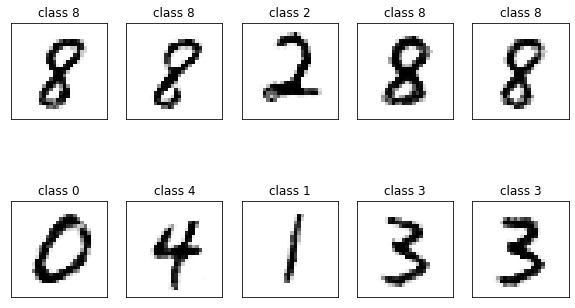

In [ ]:
cgan.generate2(n_classes=n_classes)

# **3.b Deep Convolutional Conditional GAN**

In [6]:
class Discriminator(nn.Module):
    def __init__(self, d_in=784, channels=2, n_classes=10):
        super().__init__()

        self.input_dim = d_in
        self.n_classes = n_classes
        self.channels = channels

        # architecture
        self.embed = nn.Embedding(num_embeddings=n_classes, embedding_dim=20)
        self.lin0 = nn.Linear(in_features=20, out_features=1*28*28)

        self.conv1 = nn.Conv2d(channels, 32, 4, padding=1, stride=2)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.lrelu1 = nn.LeakyReLU(inplace=True)
        self.mpool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 32, 3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.lrelu2 = nn.LeakyReLU(inplace=True)
        self.mpool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(32, 32, 2, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.lrelu3 = nn.LeakyReLU(inplace=True)
        
        self.lin1 = nn.Linear(in_features=32*4*4, out_features=1)
        self.sig = nn.Sigmoid() 

    def forward(self, x, y):

        y = self.embed(y)
        y = self.lin0(y).reshape(-1, 1, 28, 28)

        # concatenation image + label
        x = torch.cat((x, y), axis=1)

        x = self.conv1(x)
        x = self.lrelu1(self.bn1(x))
        x = self.mpool1(x)

        x = self.conv2(x)
        x = self.lrelu2(self.bn2(x))
        x = self.mpool2(x)

        x = self.conv3(x)
        x = self.lrelu3(self.bn3(x))

        x = x.view(-1, 32*4*4)

        return self.sig(self.lin1(x))


In [ ]:
class Generator(nn.Module):
    def __init__(self, d_in=784, channels=2, z=36, n_classes=10):
        super().__init__()

        self.z = z
        self.zsqrt = np.sqrt(z).astype(int)
        self.input_dim = d_in
        self.n_classes = n_classes
        self.channels = channels

        # architecture
        self.embed = nn.Embedding(num_embeddings=n_classes, embedding_dim=20)
        self.lin0 = nn.Linear(in_features=20, out_features=z)
        self.lin1 = nn.Linear(in_features=z*self.channels, out_features=self.channels*10*10)
      
        self.tconv1 = nn.ConvTranspose2d(channels, 64, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.lrelu1 = nn.LeakyReLU(inplace=True)

        self.tconv2 = nn.ConvTranspose2d(64, 64, 4, stride=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.lrelu2 = nn.LeakyReLU(inplace=True)

        self.tconv3 = nn.ConvTranspose2d(64, self.channels-1, 4, stride=2)

        self.sig = nn.Sigmoid()
        

    def forward(self, z, y):

        y = self.embed(y)
        y = self.lin0(y).reshape(-1, 1, self.zsqrt, self.zsqrt)

        # concatenation latent vector z + label
        x = torch.cat((z, y), axis=1).view(-1, self.channels*self.zsqrt*self.zsqrt)

        x = self.lin1(x).reshape(-1, self.channels, 10, 10)

        x = self.bn1(self.tconv1(x))
        x = self.lrelu1(x)

        x = self.bn2(self.tconv2(x))
        x = self.lrelu2(x)

        return self.sig(self.tconv3(x))


In [ ]:
class DCCGAN:
    def __init__(self, n_input=784, n_classes=10, z=20, channels=1):
        
        self.n_in = n_input
        self.n_out = n_classes
        self.z = z
        self.zsqrt = np.sqrt(z).astype(int)
        self.channels = channels

        # networks
        self.generator = Generator(d_in=n_input, channels=channels, z=z, n_classes=n_classes).cuda()
        print(self.generator)
        
        self.discriminator = Discriminator(d_in=n_input, channels=channels, n_classes=n_classes).cuda()
        print(self.discriminator)

        # setup optimizer
        self.optimizerD = optim.Adam(self.discriminator.parameters(), lr=1e-3, betas=(0.5, 0.999))
        self.optimizerG = optim.Adam(self.generator.parameters(), lr=1e-3, betas=(0.5, 0.999))

        self.criterion = nn.BCELoss().cuda()

        # labels
        self.real_label = 1
        self.fake_label = 0
        
    def training(self, epochs, xtrain, ytrain, xval=xval, yval=yval, verbose=True):
        
        xtrain = Variable(xtrain).cuda()
        ytrain = Variable(ytrain).cuda()
        
        xval = Variable(xval).cuda()
        yval = Variable(yval).cuda()

        # for time
        t0 = time.time()
        sec, mins = 0, 0

        loss_Dis = []
        loss_Gen = []
        acc_real = []
        acc_fake = []
        
        for epoch in range(epochs):
            for i, real_img, y in zip(range(len(xtrain)), xtrain, ytrain):

                ## training the Discriminator ##
                self.discriminator.zero_grad()
                
                # real images
                batch_size = real_img.size(0)
                label = torch.full((batch_size,), self.real_label,
                                   dtype=real_img.dtype).cuda() # label = (1, 1, ... 1)

                # forward 1
                output = self.discriminator(real_img, y).view(-1, 1).squeeze(1)  # forward D
                errD_real = self.criterion(output, label) # loss 4 real img
                errD_real.backward()
                D_x = output.mean().item()  # D(x)

                # fake images
                noise = torch.randn(batch_size, self.channels-1, self.zsqrt, self.zsqrt).cuda()
                fake = self.generator(noise, y) 

                label.fill_(self.fake_label)
                
                # forward 2
                
                output = self.discriminator(fake.detach(), y).view(-1, 1).squeeze(1)  
                errD_fake = self.criterion(output, label)  
                errD_fake.backward()
                D_G_z1 = output.mean().item()  # D(G(z))

                errD = errD_real + errD_fake  # total loss for D
                self.optimizerD.step()


                ## training the Generator ##

                self.generator.zero_grad()
                label.fill_(self.real_label)  # fake labels are real for generator cost

                output = self.discriminator(fake, y).view(-1, 1).squeeze(1)  
                errG = self.criterion(output, label)
                errG.backward()
                D_G_z2 = output.mean().item()
                self.optimizerG.step()


                ## display ##

                if i%400 == 0 and verbose:
                    loss_Dis.append(errD.item())
                    loss_Gen.append(errG.item())
                    acc_real.append(D_x)
                    acc_fake.append(D_G_z1)

                
                    # plotting
                    clear_output(wait=True)
                    plt.clf()

                    fig = plt.figure(figsize=(16, 4))
                    ax1 = plt.subplot(2, 2, 1)
                    ax2 = plt.subplot(2, 2, 3)
                    ax3 = plt.subplot(1, 2, 2)
                    plt.tight_layout(h_pad=3)

                    # losses
                    ax1.plot(range(len(loss_Dis)), loss_Dis, label=f'Discrimator loss: {loss_Dis[-1]:.2f}')
                    ax1.plot(range(len(loss_Gen)), loss_Gen, label=f'Generator loss:   {loss_Gen[-1]:.2f}')

                    ax1.set_ylabel('loss')
                    ax1.set_title(f'Loss | Epoch {epoch+1} of {epochs}')
                    ax1.legend(loc='upper right')

                    # accuracy
                    ax2.plot(range(len(acc_real)), acc_real, label=f'classification of Real (1): {acc_real[-1]:.3f}')
                    ax2.plot(range(len(acc_fake)), acc_fake, label=f'classification of Fake (0): {acc_fake[-1]:.3f}')

                    ax2.set_ylim((-0.1, 1.1))
                    ax2.set_ylabel('accuracy')
                    ax2.set_title(f'Accuracy | remaining: {mins:.0f}m {sec:.0f}s')
                    ax2.legend(loc='upper right')
                    
                    # novel images
                    targ = ytrain[np.random.randint(len(ytrain)), 0]
                    img = self.generator(torch.randn(1, self.channels-1, self.zsqrt, self.zsqrt).cuda(), 
                                                    targ.cuda()).detach().cpu().numpy()
                    img = img.reshape(28, 28) if self.channels == 2 else img.reshape(28, 28, 3)
                    ax3.imshow(img, cmap='Greys')
                    ax3.set_xticks(())
                    ax3.set_yticks(())
                    ax3.set_title(f'Generated sample: {targ.item()}')

                    plt.pause(0.0001)
                
            if epoch == 0:
                dft0 = time.time() - t0
            dft = dft0 * (epochs - epoch)
            sec = dft%60
            mins = (dft-sec)//60

        print('\n- training ended -')

    def generate(self, n_classes=2):
        fig, axs = plt.subplots(figsize=(10, 6), nrows=2, ncols=5)
        with no_grad():
            for row in range(2):
                for ax in axs[row]:
                    idx = torch.randint(n_classes, (1, 1))
                 
                    img = self.generator(torch.randn(1, self.channels-1, self.zsqrt, self.zsqrt).cuda(), 
                                    idx.cuda()).detach().cpu().numpy()
                    img = img.reshape(28, 28) if self.channels == 2 else img.reshape(28, 28, 3)
                    ax.imshow(img, cmap='Greys')
                    ax.set_xticks(())
                    ax.set_yticks(())
                    ax.set_title(f'class {idx.item()}')
                    
        plt.show()

    def generate_one(self, n_classes, idx):
        with no_grad():
            idx = torch.tensor([[idx]])
            
            img = self.generator(torch.randn(1, self.channels-1, self.zsqrt, self.zsqrt).cuda(), 
                            idx.cuda()).detach().cpu().numpy()
            img = img.reshape(28, 28) if self.channels == 2 else img.reshape(28, 28, 3)
            return img, idx

In [ ]:
dccgan = DCCGAN(n_classes=n_classes, z=49, channels=channels+1)

Generator(
  (embed): Embedding(7, 10)
  (lin0): Linear(in_features=10, out_features=49, bias=True)
  (lin1): Linear(in_features=196, out_features=400, bias=True)
  (tconv1): ConvTranspose2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lrelu1): LeakyReLU(negative_slope=0.01, inplace=True)
  (tconv2): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lrelu2): LeakyReLU(negative_slope=0.01, inplace=True)
  (tconv3): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2))
  (sig): Sigmoid()
)
Discriminator(
  (embed): Embedding(7, 10)
  (lin0): Linear(in_features=10, out_features=784, bias=True)
  (conv1): Conv2d(4, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lrelu1): LeakyReLU(negat

<Figure size 432x288 with 0 Axes>

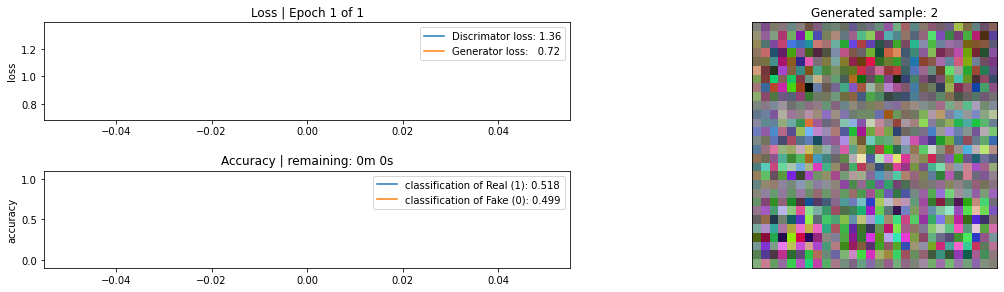


- training ended -


In [ ]:
dccgan.training(epochs=1, xtrain=xtrain, ytrain=ytrain, xval=xval, yval=yval)

# **4. Denoising AutoEncoder**


In [ ]:
class DAE:
    def __init__(self, n_input=784, channels=1):

        self.n_input = n_input
        self.channels = channels

        self.dae = nn.Sequential(
            nn.Conv2d(channels, 64, 4, padding=1, stride=2),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 64, 3, padding=1, stride=1),
            nn.BatchNorm2d(num_features=64),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 4, 2, padding=1),
            nn.BatchNorm2d(num_features=4),
            nn.LeakyReLU(inplace=True),

            nn.ConvTranspose2d(4, 64, 2, stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),

            nn.ConvTranspose2d(64, 64, 3, stride=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),

            nn.ConvTranspose2d(64, 64, 4, stride=1),
            nn.LeakyReLU(64),

            nn.ConvTranspose2d(64, channels, 4, stride=2),
            nn.Sigmoid(),
        ).cuda()

        self.optimizer = optim.Adam(self.dae.parameters(), lr=1e-4, betas=(0.5, 0.999), weight_decay=0.001)
        print(self.dae)

    def test(self, X, Xn):
        with no_grad():
            loss = 0
            for x, x_noisy in zip(X, Xn):
                x_hat = self.dae(x_noisy)
                loss += nn.functional.mse_loss(x_hat, x, reduction='sum')
                
        return loss / len(X)


    def training(self, epochs, xtrain=xtrain, xtrain_noisy=xtrain_noisy, xtest=xtest, xtest_noisy=xtest_noisy, verbose=True):
        train_losses = []
        test_losses = []

        xtrain = Variable(xtrain).cuda()
        xtrain_noisy = Variable(xtrain_noisy).float().cuda()

        xtest = Variable(xtest).cuda()
        xtest_noisy = Variable(xtest_noisy).float().cuda()

        self.dae.train()
        for epoch in range(1, epochs+1):
            train_loss = 0
            
            for i, x, x_noisy in zip(range(len(xtrain)), xtrain, xtrain_noisy):
              
                x_hat = self.dae(x_noisy)
                loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
                train_loss += loss.item()
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            
                # plotting
                if i%400 == 0 and verbose:
                    test_loss = self.test(xtest, xtest_noisy)

                    train_losses.append(train_loss/len(xtrain))
                    test_losses.append(test_loss)
                
                    clear_output(wait=True)

                    ###########################################################
                    plt.clf()
                    fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(20, 4), ncols=4)
                    ax1.plot(range(len(train_losses)), train_losses, 
                             label=f'training loss {train_losses[-1]:.2f}')
                    ax1.plot(range(len(test_losses)), test_losses, 
                             label=f'test loss {test_loss:.2f}')

                    ax1.set_ylabel('loss')
                    ax1.set_title(f'Epoch {epoch}|{epochs} - Loss')
                    ax1.legend(loc='upper right')
                    
                    idx = np.random.randint(0, len(x))

                    img_x = x[idx, ...].cpu().numpy()
                    img_x = img_x.reshape(28, 28) if self.channels == 1 else img_x.reshape(28, 28, 3)
                    ax2.imshow(img_x, cmap='Greys')
                    ax2.set_xticks(())
                    ax2.set_yticks(())
                    ax2.set_title('target image')

                    img_noisy = x_noisy[idx, ...].cpu().numpy()
                    img_noisy = img_noisy.reshape(28, 28) if self.channels == 1 else img_noisy.reshape(28, 28, 3)
                    ax3.imshow(img_noisy, cmap='Greys')
                    ax3.set_xticks(())
                    ax3.set_yticks(())
                    ax3.set_title('noisy image')
                    
                    img_hat = self.dae(x_noisy[idx, ...].reshape(1, self.channels, 28, 28)).detach().cpu().numpy()
                    img_hat = img_hat.reshape(28, 28) if self.channels == 1 else img_hat.reshape(28, 28, 3)

                    ax4.imshow(img_hat, cmap='Greys')
                    ax4.set_xticks(())
                    ax4.set_yticks(())
                    ax4.set_title('reconstructed image')
                    
                    plt.pause(0.0001)
            
            if not verbose:
                clear_output(wait=True)
                print(f'epoch: {epoch}|{epochs}')

        print('\n- training ended -')


    def reconstruct(self):

        for i, x, x_noisy in zip(range(len(xtest)), xtest, xtest_noisy):

            clear_output(wait=True)
            
            plt.clf()
            fig, (ax2, ax3, ax4) = plt.subplots(figsize=(17, 4), ncols=3)
            idx = np.random.randint(0, len(x))

            img_x = x[idx, ...].cpu().numpy()
            img_x = img_x.reshape(28, 28) if self.channels == 1 else img_x.reshape(28, 28, 3)
            ax2.imshow(img_x, cmap='Greys')
            ax2.set_xticks(())
            ax2.set_yticks(())
            ax2.set_title('target image')

            img_noisy = x_noisy[idx, ...].cpu().numpy()
            img_noisy = img_noisy.reshape(28, 28) if self.channels == 1 else img_noisy.reshape(28, 28, 3)
            ax3.imshow(img_noisy, cmap='Greys')
            ax3.set_xticks(())
            ax3.set_yticks(())
            ax3.set_title('noisy image')
            
            img_hat = self.dae(x[idx, ...].reshape(1, self.channels, 28, 28)).detach().cpu().numpy()
            img_hat = img_hat.reshape(28, 28) if self.channels == 1 else img_hat.reshape(28, 28, 3)

            ax4.imshow(img_hat, cmap='Greys')
            ax4.set_xticks(())
            ax4.set_yticks(())
            ax4.set_title('reconstructed image')
            
            plt.pause(0.3)

            if i == 100:
                break

In [ ]:
dae = DAE(channels=channels)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01, inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): LeakyReLU(negative_slope=0.01, inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 4, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.01, inplace=True)
  (11): ConvTranspose2d(4, 64, kernel_size=(2, 2), stride=(2, 2))
  (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): LeakyReLU(negative_slope=0.0

<Figure size 432x288 with 0 Axes>

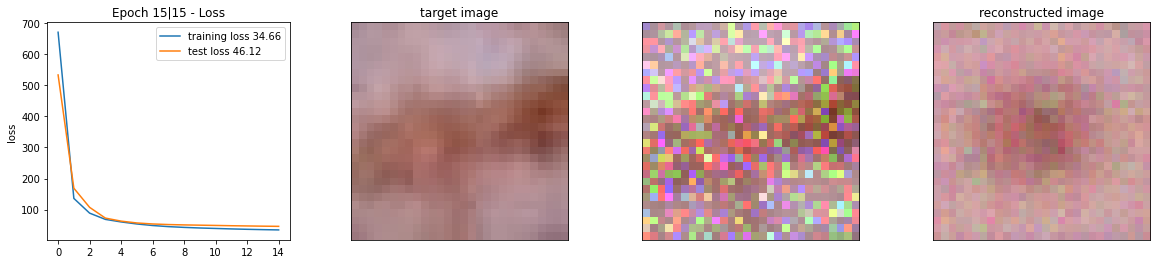


- training ended -


In [ ]:
dae.training(epochs=15, xtrain=xtrain, xtrain_noisy=xtrain_noisy, xtest=xtest, xtest_noisy=xtest_noisy, verbose=True)

# **5. Compact Run**

### data

In [4]:
# maximum common denominator, for calculating the batchsize of the training data
def MCD(n1, n2, maxb):
    values = []
    for b in range(maxb, 1, -1):
        if n1%b != 0:
            continue
        elif n2%b == 0:
            values.append(b)
    return values

In [5]:
MCD(n1=17778, n2=17778, maxb=300)

[6, 3, 2]

In [7]:
# get data and build sets
#batch_size = 107
#filename, n_classes = datasets['pneumoniamnist.npz']

#xtrain, ytrain, xtest, ytest, xval, yval, xtrain_noisy, xtest_noisy, xval_noisy, channels = build_data(filename=filename, 
#                                                                                                      n_classes=n_classes, 
#                                                                                                      batch_size=batch_size,
#                                                                                                      noise_level=0.35)
print('\n', '-'*50, '\n°n classes: ', n_classes)
print('tot batches: ', len(xtrain))
tot_batches = len(xtrain)

batch_train = MCD(n1=xtrain.shape[0], n2=xtrain.shape[0], maxb=300)

print('\nbatch sizes train sizes: ', batch_train)


 -------------------------------------------------- 
°n classes:  10
tot batches:  49000

batch sizes train sizes:  [280, 250, 245, 200, 196, 175, 140, 125, 100, 98, 70, 56, 50, 49, 40, 35, 28, 25, 20, 14, 10, 8, 7, 5, 4, 2]


In [18]:
batch_size = 250

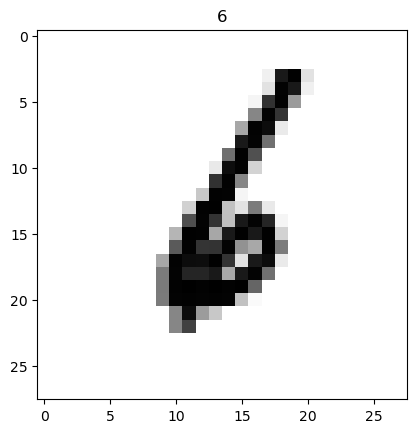

In [11]:
# display
for i in range(10):
    plt.clf()
    idx = np.random.randint(0, len(xtrain))
    plt.imshow(xtrain[idx, ...].reshape(28, 28), cmap='Greys')
    plt.title(f'{ytrain[idx]}')
    plt.pause(0.4)
    clear_output(wait=True)

### DAE

In [13]:
dae = u.DAE(channels=1)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01, inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): LeakyReLU(negative_slope=0.01, inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 4, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.01, inplace=True)
  (11): ConvTranspose2d(4, 64, kernel_size=(2, 2), stride=(2, 2))
  (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): LeakyReLU(negative_slope=0.0

In [14]:
dae.training(epochs=15, xtrain=xtrain, xtrain_noisy=xtrain_noisy, xtest=xtest, xtest_noisy=xtest_noisy, verbose=True)

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [784]

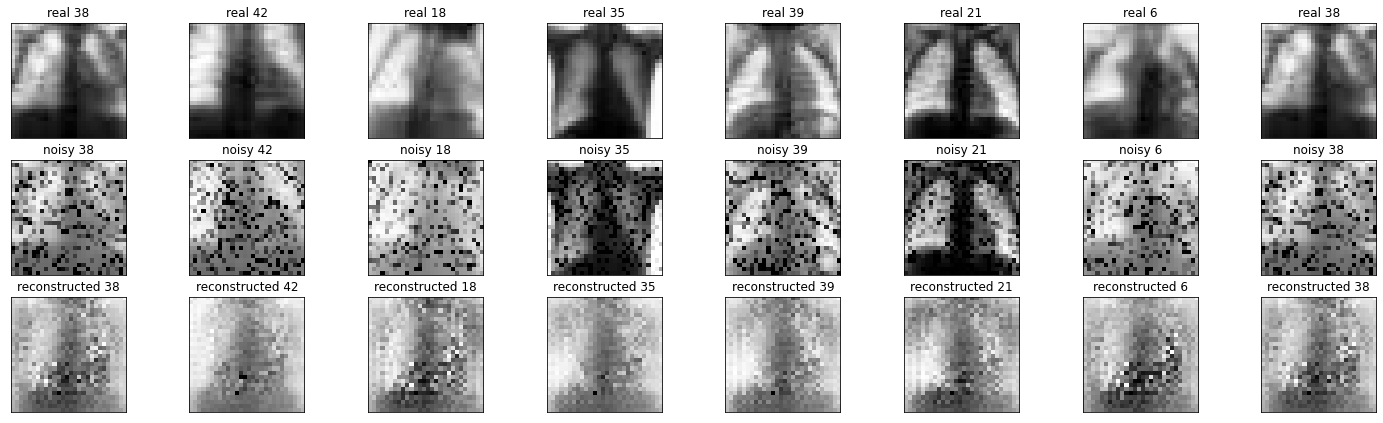

In [ ]:
fig, axs = plt.subplots(figsize=(20, 6), nrows=3, ncols=8)
plt.tight_layout(h_pad=0.1)

idxs = []
# real images
for i, ax in enumerate(axs[0]):
    idx = np.random.randint(0, len(xtrain))
    if channels == 1:
        ax.imshow(xtrain[idx, 0, ...].reshape(28, 28), cmap='Greys')
    else:
        ax.imshow(xtrain[idx, 0, ...].reshape(28, 28, 3))
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(f'real {idx}')

    idxs += [idx]

# noisy images
for j, ax in enumerate(axs[1]):
    img = xtrain_noisy[idxs[j], 0, ...].float()
    img = img.reshape(28, 28) if channels == 1 else img.reshape(28, 28, 3)
    if channels == 1:
        ax.imshow(img, cmap='Greys')
    else:
        ax.imshow(img)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(f'noisy {idxs[j]}')

# reconstructed images
for k, ax in enumerate(axs[2]):
    img = dae.dae(xtrain_noisy[idxs[k], 0, ...].float().cuda().reshape(1, channels, 28, 28)).detach().cpu().numpy()
    img = img.reshape(28, 28) if channels == 1 else img.reshape(28, 28, 3)
    if channels == 1:
        ax.imshow(img, cmap='Greys')
    else:
        ax.imshow(img)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(f'reconstructed {idxs[k]}')
        
plt.show()

### DCCVAE

In [ ]:
dccvae = DCCVAE_model(n_classes=n_classes, z=64, channels=channels+1)

DCCVAE(
  (encoder): Encoder(
    (embed): Embedding(10, 50)
    (lin0): Linear(in_features=50, out_features=784, bias=True)
    (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lrelu1): LeakyReLU(negative_slope=0.01, inplace=True)
    (mpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lrelu2): LeakyReLU(negative_slope=0.01, inplace=True)
    (mpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lrelu3): LeakyReLU(negative_slope=0.01, inplace=True)
    (lin1):

In [ ]:
dccvae.training(epochs=50, xtrain=xtrain.cuda(), ytrain=ytrain.cuda())

RuntimeError: Tensors must have same number of dimensions: got 3 and 4

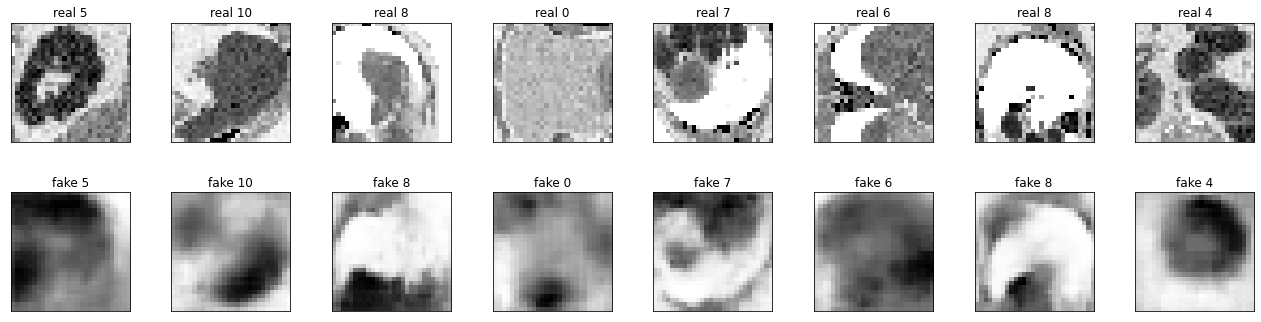

In [ ]:
fig, axs = plt.subplots(figsize=(18, 5), nrows=2, ncols=8)
plt.tight_layout(h_pad=0.1)

idxs = []
# real images
for i, ax in enumerate(axs[0]):
    idx = np.random.randint(0, len(xtrain))
    if channels == 1:
        ax.imshow(xtrain[idx, 0, ...].reshape(28, 28), cmap='Greys')
    else:
        ax.imshow(xtrain[idx, 0, ...].reshape(28, 28, 3))
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(f'real {ytrain[idx, 0]}')

    idxs += [int(ytrain[idx, 0])]

# generated images
for j, ax in enumerate(axs[1]):
    img, _ = dccvae.generate_one(n_classes=n_classes, idx=idxs[j])
    if channels == 1:
        ax.imshow(img, cmap='Greys')
    else:
        ax.imshow(img)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(f'fake {idxs[j]}')
        
plt.show()

### DCCGAN

In [ ]:
dccgan = DCCGAN(n_classes=n_classes, z=64, channels=channels+1)

Generator(
  (embed): Embedding(10, 20)
  (lin0): Linear(in_features=20, out_features=64, bias=True)
  (lin1): Linear(in_features=64, out_features=100, bias=True)
  (tconv1): ConvTranspose2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lrelu1): LeakyReLU(negative_slope=0.01, inplace=True)
  (tconv2): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lrelu2): LeakyReLU(negative_slope=0.01, inplace=True)
  (tconv3): ConvTranspose2d(64, 0, kernel_size=(4, 4), stride=(2, 2))
  (sig): Sigmoid()
)
Discriminator(
  (embed): Embedding(10, 20)
  (lin0): Linear(in_features=20, out_features=784, bias=True)
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lrelu1): LeakyReLU(nega

In [ ]:
dccgan.training(epochs=100, xtrain=xtrain.cuda(), ytrain=ytrain.cuda())

RuntimeError: Tensors must have same number of dimensions: got 3 and 4

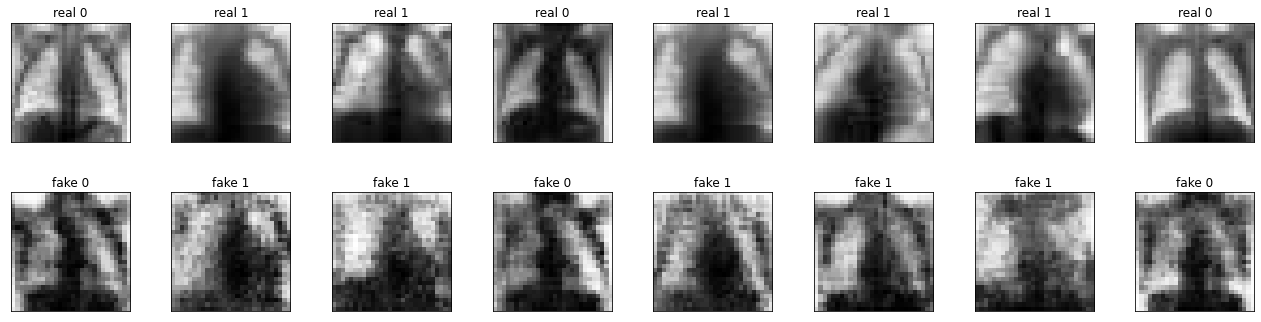

In [ ]:
fig, axs = plt.subplots(figsize=(18, 5), nrows=2, ncols=8)
plt.tight_layout(h_pad=0.1)

idxs = []
# real images
for i, ax in enumerate(axs[0]):
    idx = np.random.randint(0, len(xtrain))
    if channels == 1:
        ax.imshow(xtrain[idx, 0, ...].reshape(28, 28), cmap='Greys')
    else:
        ax.imshow(xtrain[idx, 0, ...].reshape(28, 28, 3))
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(f'real {ytrain[idx, 0]}')

    idxs += [int(ytrain[idx, 0])]

# generated images
for j, ax in enumerate(axs[1]):
    img, _ = dccgan.generate_one(n_classes=n_classes, idx=idxs[j])
    if channels == 1:
        ax.imshow(img, cmap='Greys')
    else:
        ax.imshow(img)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(f'fake {idxs[j]}')
        
plt.show()

### *CVAE*

In [ ]:
# model creation
cvae = CVAE_model(n_output=n_classes, d=150)

# training
cvae.training(epochs=20, xtrain=xtrain, ytrain=ytrain_hot)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-c2406869506f>", line 2, in <module>
    cvae = CVAE_model(n_output=n_classes, d=150)
TypeError: __init__() got an unexpected keyword argument 'n_output'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/li

TypeError: ignored

<Figure size 432x288 with 0 Axes>

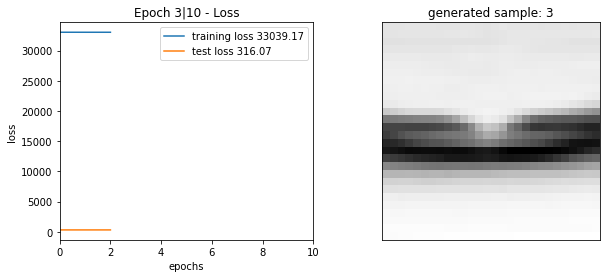

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-241-fe3efc4e95a8>", line 1, in <module>
    cvae.training(epochs=10, xtrain=xtrain, ytrain=ytrain_hot)
  File "<ipython-input-198-4cbbe454e63f>", line 95, in training
    loss.backward()
  File "/usr/local/lib/python3.6/dist-packages/torch/tensor.py", line 221, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph)
  File "/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py", line 132, in backward
    allow_unreachable=True)  # allow_unreachable flag
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError:

KeyboardInterrupt: ignored

In [ ]:
cvae.training(epochs=10, xtrain=xtrain, ytrain=ytrain_hot)

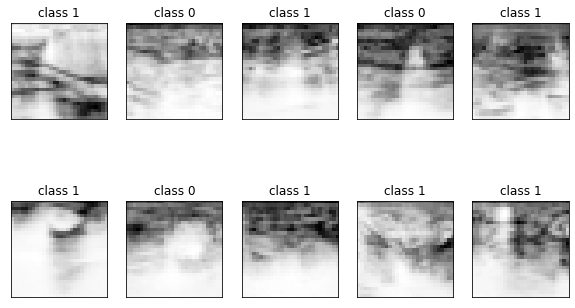

In [ ]:
fig, axs = plt.subplots(figsize=(10, 6), nrows=2, ncols=5)
for row in range(2):
    for ax in axs[row]:
        idx = np.random.randint(0, len(xtrain))
        ax.imshow(xtrain[idx, 0, 0, ...], cmap='Greys')
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(f'class {ytrain[idx, 0]}')
        
plt.show()

### *CGAN*

<Figure size 432x288 with 0 Axes>

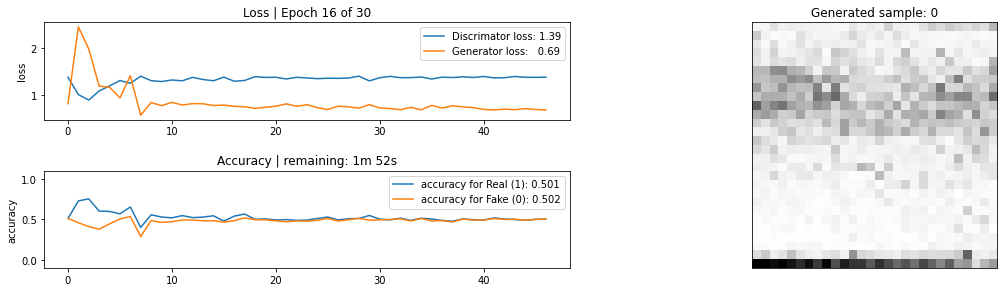

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-242-9ada76204645>", line 5, in <module>
    cgan.training(epochs=30, xtrain=xtrain, ytrain=ytrain_hot, batch_size=1, verbose=True)
  File "<ipython-input-23-968596b88d34>", line 85, in training
    self.optimizerD.step()
  File "/usr/local/lib/python3.6/dist-packages/torch/autograd/grad_mode.py", line 26, in decorate_context
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/optim/adam.py", line 80, in step
    if p.grad.is_sparse:
  File "/usr/local/lib/python3.6/dist-packages/torch/tensor.py", line 953, in grad
    return self._grad
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", li

KeyboardInterrupt: ignored

In [ ]:
# model creation
cgan = CGAN(n_output=n_classes)

# training
cgan.training(epochs=30, xtrain=xtrain, ytrain=ytrain_hot, batch_size=1, verbose=True)

# **Results**

### *Data Augmentation*

Sometimes, it happens that without the DAE the results are better (images were already quite good)

In [ ]:
# augmentation of 10% of the original dataset
volume = int(tot_batches*0.1) 
print('augmentation volume:', volume, 'new batches')

augmentation volume: 4 new batches


In [ ]:
# generate new data from a given model, optionally denoised
def new_data_generation(generator, zsqrt, channels, batch_size=1, n_batches=10, n_classes=1, denoising=False):

    labels = torch.randint(n_classes, size=(n_batches, batch_size))
    images = generator(torch.randn(batch_size, channels-1, zsqrt, zsqrt).cuda(), 
                            labels[0].cuda()).detach().cpu().reshape(1, -1, channels-1, 28, 28)

    if denoising:
        images = dae.dae(images[0].cuda()).detach().cpu().unsqueeze(0)

    for i in range(n_batches-1):
        new_batch = generator(torch.randn(batch_size, channels-1, zsqrt, zsqrt).cuda(), 
                            labels[i].cuda()).detach().cpu().reshape(1, -1, channels-1, 28, 28)
        if denoising:
            new_batch = dae.dae(new_batch[0].cuda()).detach().cpu().unsqueeze(0)
                            
        images = torch.cat((images, new_batch), axis=0)
        
    print('images shape: ', images.shape, '\nlabel shape:  ', labels.shape)
    return images, labels

DCCVAE

In [ ]:
x_vae, y_vae = new_data_generation(generator=dccvae.cvae.decoder, 
                                   zsqrt=dccvae.cvae.zsqrt, 
                                   channels=dccvae.channels, n_classes=n_classes, 
                                   batch_size=batch_size,
                                   n_batches=volume,
                                   denoising=False)

print('\n', '-'*100, '\n')
print('original xtrain: ', xtrain.shape, '\noriginal ytrain: ', ytrain.shape, '\n')
big_xtrain_vae = torch.cat((xtrain, x_vae), axis=0)
big_ytrain_vae = torch.cat((ytrain, y_vae), axis=0)
print('augmented xtrain: ', big_xtrain_vae.shape, '\naugmented ytrain: ', big_ytrain_vae.shape)

images shape:  torch.Size([4, 107, 1, 28, 28]) 
label shape:   torch.Size([4, 107])

 ---------------------------------------------------------------------------------------------------- 

original xtrain:  torch.Size([44, 107, 1, 28, 28]) 
original ytrain:  torch.Size([44, 107]) 

augmented xtrain:  torch.Size([48, 107, 1, 28, 28]) 
augmented ytrain:  torch.Size([48, 107])


DCCGAN

In [ ]:
x_gan, y_gan = new_data_generation(generator=dccgan.generator, 
                                   zsqrt=dccgan.zsqrt, channels=dccgan.channels, n_classes=n_classes, 
                                   batch_size=batch_size,
                                   n_batches=volume,
                                   denoising=False)

print('\n', '-'*100, '\n')
print('original xtrain: ', xtrain.shape, '\noriginal ytrain: ', ytrain.shape, '\n')
big_xtrain_gan = torch.cat((xtrain, x_gan), axis=0)
big_ytrain_gan = torch.cat((ytrain, y_gan), axis=0)
print('augmented xtrain: ', big_xtrain_gan.shape, '\naugmented ytrain: ', big_ytrain_gan.shape)

images shape:  torch.Size([4, 107, 1, 28, 28]) 
label shape:   torch.Size([4, 107])

 ---------------------------------------------------------------------------------------------------- 

original xtrain:  torch.Size([44, 107, 1, 28, 28]) 
original ytrain:  torch.Size([44, 107]) 

augmented xtrain:  torch.Size([48, 107, 1, 28, 28]) 
augmented ytrain:  torch.Size([48, 107])


### *Pre-augmentation*

In [ ]:
epochs = 20

# model creation
cnn = u.CNN(n_output=n_classes, channels=1)

# training
cnn.training(epochs=epochs, x_train=xtrain, y_train=ytrain, x_val=xval, y_val=yval, x_test=xtest, y_test=ytest)

In [ ]:
epochs = 20

# model creation
cnn = CNN(n_output=n_classes, channels=channels)

# training
cnn.training(epochs=epochs, x_train=xtrain, y_train=ytrain, x_val=xval, y_val=yval, x_test=xtest, y_test=ytest)

Epoch: 5	loss: 0.100	acc: 97.14%

+training ended+

 --------------------------------------------------

test accuracy: 87.40%


### *Post-Augmentation*

DC-CVAE augmentation

In [ ]:
# model creation
cnn = CNN(n_output=n_classes, channels=channels)

# training
cnn.training(epochs=epochs, x_train=big_xtrain_vae, y_train=big_ytrain_vae, x_val=xval, y_val=yval, x_test=xtest, y_test=ytest)

Epoch: 19	loss: 0.791	acc: 96.95%

+training ended+

 --------------------------------------------------

test accuracy: 87.60%


DC-GAN augmentation

In [ ]:
# model creation
cnn = CNN(n_output=n_classes, channels=channels)

# training
cnn.training(epochs=epochs, x_train=big_xtrain_gan, y_train=big_ytrain_gan, x_val=xval, y_val=yval, x_test=xtest, y_test=ytest)

Epoch: 19	loss: 0.745	acc: 96.37%

+training ended+

 --------------------------------------------------

test accuracy: 88.74%
